# Stochastic Modeling for Latency Arbitrage Detection Using Bayesian Inference

## Introduction and Motivation

As a risk analyst in high-frequency trading environments, one of my daily tasks is to identify signs of **latency arbitrage** — a situation where a client leverages millisecond-level delays between market data and execution systems to extract consistent profit. Such strategies may appear benign in aggregate, but often involve systematic exploitation of **market microstructure inefficiencies**.

In practice, the most reliable way to detect this behavior is through **manual visual analysis of individual trades**, looking for a high frequency of **short-duration, sharply profitable transactions**. This typically requires overlaying trade points on **tick-level price charts**, and visually assessing the client's timing precision relative to price micro-movements.

However, in many real-world cases, **tick-level quote data is unavailable or incomplete**, especially for:
- historical trades,
- internal routing between venues,
- or lightly traded symbols.

Even when tick data exists, retrieving and visualizing it **across the full client trading history** places a **significant burden on backend databases and analytics infrastructure**, making systematic, scalable anomaly detection impractical via traditional replay tools.

---

This leads to the central research question:

> **Can we estimate the probability that a given trade is arbitrage-like, using only its open price, close price, and holding time — without requiring tick-level market data or full order book replay?**

---

To address this, we propose a **transaction-level probabilistic model** that infers arbitrage-likeness from minimal trade metadata. Rather than assessing behavior at the client or strategy level, we evaluate **each trade individually**, using only:

- open price,
- close price,
- holding duration.

Despite this extreme data reduction, the model leverages **fundamental probabilistic laws of price behavior** and compares two competing stochastic regimes:

- A **Jump-Diffusion model**, representing normal market fluctuations with occasional noise-driven price jumps;
- A **heavy-tailed, skewed model** (specifically, the **Normal Inverse Gaussian distribution**), capturing concentrated, sharp upward moves typical for latency arbitrage.

---

The **arbitrage probability** is computed via **Bayesian likelihood ratio inference**, evaluating which model more plausibly explains the observed return over the holding period. The method is scalable, interpretable, and works **even in the absence of tick-by-tick quote data**.

Preliminary results demonstrate that the model:
- accurately identifies **statistically anomalous trades**,
- generalizes across instruments,
- and aligns well with manual visual assessments.

In particular, it shows strong detection power on **indices and FX pairs** with known microstructure gaps.




## 🔬 Full Mathematical Derivation of Arbitrage Probability Functional

We formalize the detection of arbitrage-like trades as a **Bayesian hypothesis test** between two stochastic models of log-return.

We define the stochastic hypothesis model as:

&nbsp;


$$
\begin{cases}
H_0: & x \sim \text{JumpDiffusion}(\mu, \sigma, \lambda, \mu_J, \sigma_J), \quad \text{(Regular market behavior)} \\\\
H_1: & x \sim \text{NIG}(\alpha, \beta, \mu, \delta), \quad \text{(Arbitrage-like behavior)}
\end{cases}
$$

&nbsp;



Let $x \in \mathbb{R}$ be the log-return of a transaction over time interval $T$.  
We aim to compute the **posterior probability** that this return was generated by the arbitrage model $H_1$.


---

### 1. Bayes Theorem for Posterior Probability

The arbitrage probability functional is given by:

$$
\mathcal{A}(x, T) = \mathbb{P}(H_1 \mid x, T) =
\frac{p(H_1)\,f_1(x)}{p(H_1)\,f_1(x) + p(H_0)\,f_0(x \mid T)}
$$

Here:
- $f_0(x \mid T)$: likelihood under Jump-Diffusion
- $f_1(x)$: likelihood under NIG
- $p(H_1) \in (0, 1)$: prior arbitrage probability

---

### 2. Merton Jump-Diffusion Stochastic Process ($H_0$)

We assume log-price follows:

$$
\log S_T - \log S_0 =
\left(\mu - \lambda \kappa - \frac{1}{2}\sigma^2\right) T +
\sigma W_T + \sum_{i=1}^{N_T} J_i
$$

Where:
- $W_T \sim \mathcal{N}(0, T)$: Brownian motion
- $N_T \sim \text{Poisson}(\lambda T)$: number of jumps
- $J_i \sim \mathcal{N}(\mu_J, \sigma_J^2)$: jump sizes
- $\kappa = \mathbb{E}[e^{J_i}] - 1 = e^{\mu_J + \frac{1}{2} \sigma_J^2} - 1$

Thus, conditionally on $N_T = n$, the log-return $x$ follows:


$$
x \mid (N_T = n) \sim \mathcal{N}(\mu_n, \sigma_n^2)
$$

Where:
- $\mu_n = (\mu - \lambda \kappa - \frac{1}{2}\sigma^2)T + n \mu_J$
- $\sigma_n^2 = \sigma^2 T + n \sigma_J^2$

Hence, the **unconditional density** is a mixture:

$$
f_0(x \mid T) = \sum_{n=0}^{\infty}
\underbrace{
\frac{e^{-\lambda T} (\lambda T)^n}{n!}
}_{\text{Poisson weight}}
\cdot
\underbrace{
\frac{1}{\sqrt{2\pi \sigma_n^2}} \exp\left(
- \frac{(x - \mu_n)^2}{2\sigma_n^2}
\right)
}_{\text{Normal pdf}}
$$

This expression is **analytically intractable**, but can be **approximated numerically** by truncating the sum at some $n_{\max}$.

---

### 3. Normal Inverse Gaussian Stochastic Process ($H_0$)

The **NIG distribution** is defined as:

&nbsp;


$$
f_1(x) =
\frac{\alpha \delta}{\pi}
\cdot
\frac{K_1\left(\alpha \sqrt{\delta^2 + (x - \mu)^2}\right)}
{\sqrt{\delta^2 + (x - \mu)^2}}
\cdot
\exp\left( \delta \sqrt{\alpha^2 - \beta^2} + \beta(x - \mu) \right)
$$

&nbsp;


Where:
- $\alpha > |\beta|$: shape parameter (tail thickness)
- $\beta$: asymmetry (positive → skewed right)
- $\delta > 0$: scale
- $\mu$: location
- $K_1$: modified Bessel function of the second kind

This form allows modeling **heavy right tails**, which are expected under arbitrage.

---

### 4. Substituting into Bayesian Formula

Let’s denote:
- $p = p(H_1)$
- $f_0(x) = f_0(x \mid T)$
- $f_1(x)$: NIG pdf

Then the functional becomes:

$$
\mathcal{A}(x, T) =
\frac{p \cdot f_1(x)}{p \cdot f_1(x) + (1 - p) \cdot f_0(x)}
$$

Substituting $f_0(x)$ and $f_1(x)$ explicitly, we get very terryfing and scary expression for **arbitrage probability**:

&nbsp;

$$
\mathcal{A}(x, T) =
\frac{
p \cdot
\left[
\frac{\alpha \delta}{\pi}
\cdot
\frac{K_1\left(\alpha \sqrt{\delta^2 + (x - \mu)^2}\right)}
{\sqrt{\delta^2 + (x - \mu)^2}}
\cdot
\exp\left( \delta \sqrt{\alpha^2 - \beta^2} + \beta(x - \mu) \right)
\right]
}{
p \cdot
\left[
\frac{\alpha \delta}{\pi}
\cdot
\frac{K_1\left(\alpha \sqrt{\delta^2 + (x - \mu)^2}\right)}
{\sqrt{\delta^2 + (x - \mu)^2}}
\cdot
\exp\left( \delta \sqrt{\alpha^2 - \beta^2} + \beta(x - \mu) \right)
\right]
+
(1 - p) \cdot
\sum_{n=0}^{n_{\max}}
\frac{e^{-\lambda T} (\lambda T)^n}{n!}
\cdot
\frac{1}{\sqrt{2\pi \sigma_n^2}} \exp\left(
- \frac{(x - \mu_n)^2}{2\sigma_n^2}
\right)
}
$$

&nbsp;


This gives a closed-form expression for **arbitrage probability** given log-return and trade duration.

---

### 5. Numerical Implementation Notes

- Truncate JD mixture at $n_{\max} = 20$
- Precompute $\mu_n$, $\sigma_n$ for each $n$
- Evaluate Bessel function $K_1$ using `scipy.special.k1`
- For speed, use `scipy.stats.norminvgauss.pdf` and `scipy.stats.norm.pdf`
- All model parameters (both for JD and NIG) are assumed fixed and pre-specified.

This assumption is justified for two main reasons:

1. It enables **consistent probabilistic scoring** across different instruments and trades;
2. It avoids overfitting to local noise in small or heterogeneous samples.

The fixed parameters represent a *reference market regime* (null hupothesis) and an *idealized arbitrage profile* (alternative), which we test each trade against.


---

### 6. Interpretation of Output

- $\mathcal{A}(x, T) \approx 0$: consistent with JD model → regular market return  
- $\mathcal{A}(x, T) \to 1$: JD model cannot explain return → strong arbitrage candidate  
- Middle values (e.g., $\sim 0.05$) indicate borderline behavior between regular and anomalous trades

---

### 7. Example Parameters (used in experiment)

Jump-Diffusion:
$$
\mu = 0.1, \quad \sigma = 0.2, \quad
\lambda = 0.3, \quad \mu_J = -0.05, \quad \sigma_J = 0.1
$$

NIG:
$$
\alpha = 3.0, \quad \beta = 1.5, \quad \mu = 0.1, \quad \delta = 0.05
$$

These parameter choices are intentionally fixed and interpretable:

- **Jump-Diffusion stochastic process** reflects a typical efficient market regime:
  - $\mu = 0.1$: modest positive drift, consistent with long-term asset growth
  - $\sigma = 0.2$: moderate market volatility
  - $\lambda = 0.3$: rare jumps (approx. once every few days in trading time)
  - $\mu_J = -0.05$: negative average jump — reflecting risk shocks or corrections
  - $\sigma_J = 0.1$: small jump variance, making most jumps mild

&nbsp;

- **NIG stochastic process** represents an idealized arbitrage return profile:
  - $\alpha = 3.0$: moderately heavy tails, allowing for outliers
  - $\beta = 1.5$: strong right-skewness — capturing sharp upward profits
  - $\mu = 0.1$: centered around same drift as JD for comparability
  - $\delta = 0.05$: narrow scale — high kurtosis, extreme events are concentrated


Together, these choices separate "normal" noisy market behavior from "surgical", sharp profit patterns typical of arbitrage.

**Note on time scaling:**

All parameters in both models — particularly drift $\mu$, volatility $\sigma$, jump intensity $\lambda$, and jump variance $\sigma_J^2$ — are specified on an **annualized basis**.

That is:

- $\mu$ is the expected log-return **per year**,
- $\sigma$ is the standard deviation of log-return **per square root of year**,
- $\lambda$ is the expected number of jumps **per year**,
- $\mu_J$ and $\sigma_J$ describe the mean and standard deviation of jump sizes, **per event**, assuming a yearly framework.

In numerical implementation, each transaction’s duration $T$ (measured in seconds or minutes) is **converted to years** via:

&nbsp;


$$
T = \frac{\text{duration\_in\_seconds}}{365 \times 24 \times 60 \times 60}
$$

&nbsp;


This ensures that all time-dependent expressions such as $\mu T$, $\sigma \sqrt{T}$, and $\lambda T$ remain **dimensionally correct**.

---

**Why this does not affect the reliability of arbitrage probability calculations:**

1. The probability functional $\mathcal{A}(x, T)$ depends on the **relative likelihoods** $f_1(x)$ and $f_0(x \mid T)$, not on absolute values. As long as $T$ is scaled consistently, the comparison remains valid.

2. The JD model internally scales variance and jump intensity using $T$, so **short durations** (minutes or seconds) are naturally reflected in smaller variances and fewer expected jumps — without changing model structure.

3. Using annualized parameters provides **stability** and avoids overfitting to noisy short-term fluctuations, especially when trade durations vary widely across the dataset.

Therefore, keeping the model annualized is not only dimensionally consistent, but also improves **robustness** and interpretability of the arbitrage probability estimates.


---


Let's start with importing a trading history of the client that was revealed by our risk management department as a latency arbitrage trader and perform analysis described above:

In [75]:
df = pd.read_excel(r"C:\Users\User\Downloads\Telegram Desktop\Arbitrage trader.xlsx")
df[['TICKET','SYMBOL','VOLUME','OPEN_TIME','OPEN_PRICE','CLOSE_TIME','CLOSE_PRICE','PROFIT_USD']].head(10)

,TICKET,SYMBOL,VOLUME,OPEN_TIME,OPEN_PRICE,CLOSE_TIME,CLOSE_PRICE,PROFIT_USD
0,5076685125,USDJPY_o,1.0,2023-08-29 15:30:40,147.339,2023-08-29 15:30:57,147.321,8.72
1,5076689048,USDJPY_o,0.5,2023-08-29 15:46:50,147.240,2023-08-29 15:49:01,147.210,8.44
2,5076689230,USDJPY_o,0.5,2023-08-29 15:49:39,147.232,2023-08-29 15:50:17,147.201,8.78
3,5076691778,USDJPY_o,0.5,2023-08-29 15:53:16,147.219,2023-08-29 16:02:02,147.165,16.60
4,5076693940,USDJPY_o,0.5,2023-08-29 16:10:19,147.216,2023-08-29 16:11:18,147.187,8.10
5,5076694612,USDJPY_o,2.0,2023-08-29 16:13:32,147.153,2023-08-29 16:14:58,147.167,12.03
6,5076698086,USDJPY_o,2.0,2023-08-29 16:31:46,147.180,2023-08-29 16:32:04,147.203,24.25
7,5076698728,USDJPY_o,0.5,2023-08-29 16:25:20,147.220,2023-08-29 16:34:01,147.192,7.76
8,5076700185,USDJPY_o,5.0,2023-08-29 16:38:40,147.243,2023-08-29 16:39:23,147.225,43.63
9,5076705289,USDJPY_o,1.0,2023-08-29 15:40:26,147.209,2023-08-29 16:56:14,147.114,61.08


In [76]:
df.SYMBOL.value_counts()

SYMBOL
FDAX        171
USDJPY_o    133
XAUUSD_o    111
NQ           81
EURUSD_o     42
EURJPY_o     11
GBPUSD_o      3
Name: count, dtype: int64

As we can see, client used different trading instruments and different trade's duration and it is not so clear whether short trade is an example of arbitrage or not. Now, we will define our Stochastic Processes and compute Arbitrage Probability for each trade in accordance with Bayesian inference and out null and alternative hypothesis:

In [78]:
from scipy.stats import norm, norminvgauss
from scipy.special import factorial
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations


# Jump-Diffusion Stochastic Process parameters (H0 hypothesis)
mu = 0.1
sigma = 0.2
lambda_jump = 0.3
mu_J = -0.05
sigma_J = 0.1
max_jumps = 20

# Normal Inverse Gaussian Stochastic Process parameters (H1 - arbitrage)
alpha_nig = 3.0
beta_nig = 1.5
mu_nig = 0.1
delta_nig = 0.05

# A priori probability of arbitrage
prior_H1 = 0.05  # it is not so likely to find such type of trading strategy 

df['OPEN_TIME'] = pd.to_datetime(df['OPEN_TIME'])
df['CLOSE_TIME'] = pd.to_datetime(df['CLOSE_TIME'])
df['DURATION_YEARS'] = (df['CLOSE_TIME'] - df['OPEN_TIME']).dt.total_seconds() / (365 * 24 * 3600)

df['ADJ_CLOSE_PRICE'] = df.apply(lambda row:
                                 row['CLOSE_PRICE'] if row['CMD'].upper() == 'BUY'
                                 else 2 * row['OPEN_PRICE'] - row['CLOSE_PRICE'], axis=1)

df['LOG_RETURN'] = np.log(df['ADJ_CLOSE_PRICE'] / df['OPEN_PRICE'])


def jd_pdf(x, T):
    kappa = np.exp(mu_J + 0.5 * sigma_J ** 2) - 1
    total_pdf = 0.0
    for n in range(max_jumps + 1):
        pois_weight = np.exp(-lambda_jump * T) * (lambda_jump * T) ** n / factorial(n)
        mu_n = (mu - lambda_jump * kappa - 0.5 * sigma ** 2) * T + n * mu_J
        sigma_n = np.sqrt(sigma ** 2 * T + n * sigma_J ** 2)
        total_pdf += pois_weight * norm.pdf(x, loc=mu_n, scale=sigma_n)
    return total_pdf


def nig_pdf(x):
    return norminvgauss.pdf(x, a=alpha_nig, b=beta_nig, loc=mu_nig, scale=delta_nig)


def arbitrage_prob_nig(row):
    x = row['LOG_RETURN']
    T = row['DURATION_YEARS']
    f0 = jd_pdf(x, T)
    f1 = nig_pdf(x)
    numerator = prior_H1 * f1
    denominator = numerator + (1 - prior_H1) * f0
    return numerator / denominator if denominator > 0 else np.nan


df['ARBITRAGE_PROB_NIG'] = df.apply(arbitrage_prob_nig, axis=1)

That's it. We have computed all we need. Now, let us visualize arbitrage and ordinary trades in terms of Stochastic modeling and Bayesian inference:

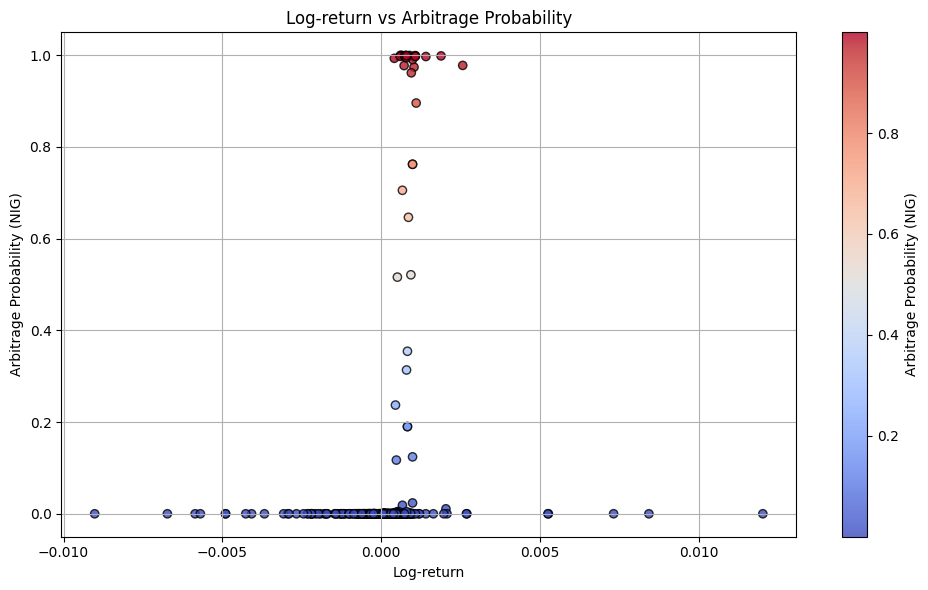

In [79]:
x_vals_dense = np.linspace(df['LOG_RETURN'].min() - 0.01, df['LOG_RETURN'].max() + 0.01, 300)
T_fixed = 1e-5 

plt.figure(figsize=(10, 6))

sc = plt.scatter(df['LOG_RETURN'], df['ARBITRAGE_PROB_NIG'],
                 c=df['ARBITRAGE_PROB_NIG'], cmap='coolwarm', alpha=0.8, edgecolors='k')
plt.colorbar(sc, label='Arbitrage Probability (NIG)')

plt.xlabel('Log-return')
plt.ylabel('Arbitrage Probability (NIG)')
plt.title('Log-return vs Arbitrage Probability')
plt.grid(True)
plt.tight_layout()
plt.show()


As illustrated in the figure above, the arbitrage probability functional $\mathcal{A}(x, T)$ clearly identifies a distinct cluster of trades with **high posterior probability** ($\mathcal{A} \approx 1$), corresponding to sharp log-returns concentrated near zero duration.

These points appear visibly separated from the dense region of low-probability trades, forming a narrow column of **outliers** in terms of model likelihood under the null (Jump-Diffusion). This pattern suggests that the functional effectively isolates transactions that the regular stochastic process cannot plausibly explain.

> Even to the naked eye, a clear distinction emerges between high-confidence arbitrage-like trades and the rest of the distribution — validating the interpretability of the scoring method.

Let's have a look on these trades in detail:

In [82]:
df[df['ARBITRAGE_PROB_NIG'] > 0.1][['TICKET','SYMBOL','OPEN_TIME','OPEN_PRICE','CLOSE_TIME','CLOSE_PRICE','VOLUME','PROFIT_USD', "ARBITRAGE_PROB_NIG"]]

,TICKET,SYMBOL,OPEN_TIME,OPEN_PRICE,CLOSE_TIME,CLOSE_PRICE,VOLUME,PROFIT_USD,ARBITRAGE_PROB_NIG
226,5078395532,NQ,2023-09-13 17:26:44,15315.4,2023-09-13 17:26:51,15327.5,5.0,0.0,0.998845
279,5078704759,NQ,2023-09-15 16:34:10,15383.7,2023-09-15 16:34:20,15394.8,5.0,0.0,0.976951
285,5078715080,NQ,2023-09-15 17:01:37,15317.3,2023-09-15 17:01:43,15309.5,5.0,0.0,0.515881
293,5078728673,NQ,2023-09-15 17:48:38,15274.6,2023-09-15 17:48:41,15283.9,5.0,0.0,0.999496
332,5078868089,FDAX,2023-09-18 15:59:42,15765.6,2023-09-18 15:59:45,15772.1,5.0,0.0,0.992848
349,5078877640,NQ,2023-09-18 16:32:58,15177.5,2023-09-18 16:33:04,15191.1,5.0,0.0,0.999020
351,5078877786,NQ,2023-09-18 16:33:23,15191.9,2023-09-18 16:33:34,15208.1,5.0,0.0,0.998236
352,5078877795,NQ,2023-09-18 16:33:18,15191.9,2023-09-18 16:33:36,15207.6,5.0,0.0,0.996202
353,5078877800,NQ,2023-09-18 16:33:17,15191.9,2023-09-18 16:33:38,15207.6,5.0,0.0,0.973561
354,5078877803,NQ,2023-09-18 16:33:22,15191.9,2023-09-18 16:33:40,15206.3,5.0,0.0,0.961183


A notable observation is that many trades identified by the model as having **high arbitrage probability** (e.g., $\mathcal{A} > 0.9$) are recorded with **zero profit** in the `PROFIT_USD` field.

This outcome is not a failure of the model, but rather reflects the fact that these trades had **already been identified and addressed by our internal risk management team** prior to model evaluation.

> **The fact that these zero-profit trades still receive high arbitrage scores confirms that the model is capturing the same risk patterns as our expert review process — but in a scalable, automated fashion.**

This alignment between model output and prior expert intervention reinforces the validity of the approach and its potential to serve as a **first-level filter** for future risk monitoring workflows.

## 8. Conclusion

This methodology provides a statistically grounded and computationally efficient way to estimate the likelihood that a given trade exhibits arbitrage-like behavior — based solely on open price, close price, and holding duration.

By combining a Jump-Diffusion model for regular market behavior with a heavy-tailed, skewed NIG distribution to model arbitrage signatures, we construct a Bayesian decision rule that is both interpretable and scalable across large datasets.

The resulting arbitrage probability is:

- **calibrated** to reflect deviations from expected stochastic price dynamics,
- **agnostic** to client identity, trading volume, or venue,
- and **robust** in the absence of tick-level market data.

However, it is important to emphasize that this is **not a substitute for expert trade review or dealer judgment**.

Rather, it is intended as a **supportive tool** — a probabilistic signal that flags trades potentially worthy of manual inspection. In this sense, it can act as a **first-pass filter** within a broader risk-monitoring framework.

The methodology is well-suited for integration into:
- internal monitoring dashboards,
- post-trade analytics,
- or real-time scoring modules on a broker's website.

When used appropriately, it enables more **proactive**, **explainable**, and **scalable** oversight of client trading behavior — especially in environments where detailed market data is limited or computational resources are constrained.
